In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import array_sensitivity
import importlib
importlib.reload(array_sensitivity)
from matplotlib.patches import Rectangle
import scipy
import seaborn

In [2]:
# Set instrument parameters
antpos_filepath = "W2-17.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k = 25
aperture_efficiency = 0.7
field_of_view_deg2 = 30.0
antenna_diameter_m = 5
freq_resolution_hz = 130.2e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = 1000
bao_scales_k = np.array([.03, .2]) / 0.71

In [3]:
antpos = array_sensitivity.get_antpos(antpos_filepath)

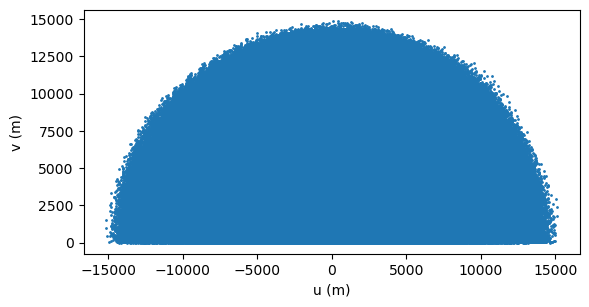

In [4]:
# Get baselines
baselines_m = array_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

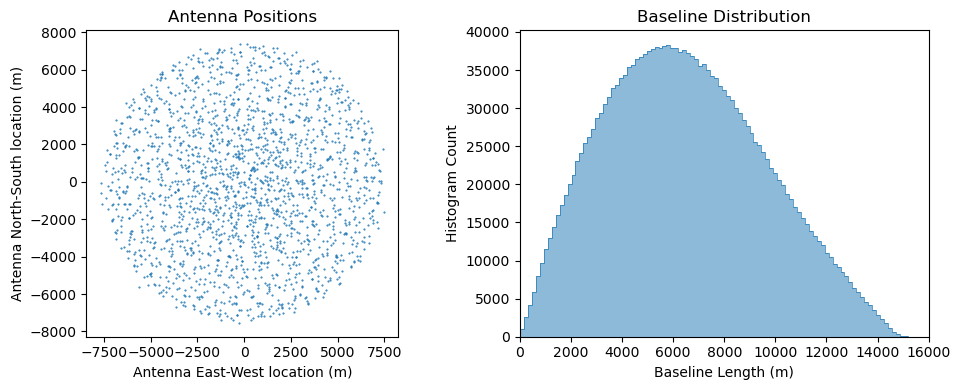

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax[0].plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0, color="tab:blue")
ax[0].set_aspect(1)
ax[0].set_xlabel("Antenna East-West location (m)")
ax[0].set_ylabel("Antenna North-South location (m)")
ax[0].set_title("Antenna Positions")
ax[0].set_aspect("equal")

ax[1].hist(
    np.sqrt(np.sum(baselines_m**2., axis=1)),
    bins=100, color="tab:blue",
    alpha=0.5,
)
ax[1].hist(
    np.sqrt(np.sum(baselines_m**2., axis=1)),
    bins=100,
    linewidth=.5,
    edgecolor="tab:blue",
    histtype="step"
)
ax[1].set_xlabel("Baseline Length (m)")
ax[1].set_ylabel("Histogram Count")
ax[1].set_title("Baseline Distribution")
ax[1].set_xlim([0,16000])

plt.tight_layout()
plt.savefig("plots/antlocs.png", dpi=600)
plt.show()

In [6]:
# Define bin edges:
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)
delay_array_s = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array_hz), d=freq_resolution_hz)
)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
max_kpar = kpar_conv_factor * np.max(delay_array_s)

kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
max_baseline_wl = np.max(np.sqrt(np.sum(baselines_m**2.0, axis=1))) * max_freq_hz / c
max_kperp = kperp_conv_factor * max_baseline_wl
max_k = np.sqrt(max_kpar**2.0 + max_kperp**2.0)

k_bin_size = 0.1
min_k = 0.02
bin_edges = np.arange(min_k, max_k, k_bin_size)
kpar_bin_edges = np.arange(0, max_kpar, k_bin_size)
kperp_bin_edges = np.arange(0, max_kperp, k_bin_size)

# Run in notebook
#max_k = 5
#bin_edges = np.arange(min_k, max_k, k_bin_size)
#kpar_bin_edges = np.copy(bin_edges)
#kperp_bin_edges = np.copy(bin_edges)

In [7]:
# Restore simulation with horizon wedge cut
with open("simulation_outputs/thermal_noise_no_core_wedge_cut_horizon_za_0.0.npy", "rb") as f:
    nsamples_horizon_cut = np.load(f)
    binned_ps_variance_horizon_cut = np.load(f)
    true_bin_edges_horizon_cut = np.load(f)
    true_bin_centers_horizon_cut = np.load(f)
    nsamples_2d_restored = np.load(f)
    binned_ps_variance_2d_restored = np.load(f)
f.close()

In [8]:
# Restore simulation with FoV wedge cut
with open("simulation_outputs/thermal_noise_no_core_wedge_cut_fov_za_0.0.npy", "rb") as f:
    nsamples_fov_cut = np.load(f)
    binned_ps_variance_fov_cut = np.load(f)
    true_bin_edges_fov_cut = np.load(f)
    true_bin_centers_fov_cut = np.load(f)
f.close()

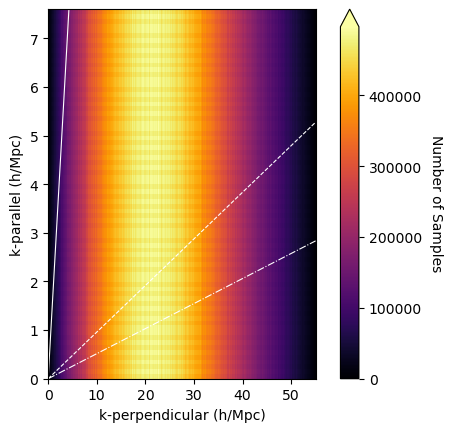

In [9]:
# Make 2D Nsamples plot from restored data

# Get wedge slope
kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
wedge_slope = kpar_conv_factor / (kperp_conv_factor * freq_hz)

field_of_view_radius = 3.09
fov_wedge_slope = wedge_slope * np.sin(np.radians(field_of_view_radius))
half_max_radius = 1.66
half_max_slope = wedge_slope * np.sin(np.radians(half_max_radius))

fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    nsamples_2d_restored.T,
    origin="lower",
    interpolation="none",
    extent=[
        np.min(kperp_bin_edges),
        np.max(kperp_bin_edges),
        np.min(kpar_bin_edges),
        np.max(kpar_bin_edges)
    ],
    vmin=0,
    vmax=np.max(nsamples_2d_restored),
    cmap=use_cmap,
    #norm="log",
    aspect=10.,
)
ax.set_xlabel("k-perpendicular (h/Mpc)")
ax.set_ylabel("k-parallel (h/Mpc)")
ax.set_xlim([0, 55])
ax.set_ylim([0, np.max(kpar_bin_edges)])
plt.plot([0, 55], [0, wedge_slope*55], c="white", linewidth=.8)
plt.plot([0, 55], [0, fov_wedge_slope*55], "--", c="white", linewidth=.8)
plt.plot([0, 55], [0, half_max_slope*55], "-.", c="white", linewidth=.8)
#ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Number of Samples", rotation=270, labelpad=15)
plt.savefig("plots/2d_nsampes.png", dpi=600)
plt.show()

In [10]:
# Run horizon cut simulation in notebook
"""
(
    nsamples_horizon_cut,
    binned_ps_variance_horizon_cut,
    true_bin_edges_horizon_cut,
    true_bin_centers_horizon_cut,
    nsamples_2d_horizon_cut,
    binned_ps_variance_2d_horizon_cut,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    wedge_extent_deg=90.0,
    zenith_angle=0.0,
)
"""

'\n(\n    nsamples_horizon_cut,\n    binned_ps_variance_horizon_cut,\n    true_bin_edges_horizon_cut,\n    true_bin_centers_horizon_cut,\n    nsamples_2d_horizon_cut,\n    binned_ps_variance_2d_horizon_cut,\n) = array_sensitivity.delay_ps_sensitivity_analysis(\n    antpos_filepath=antpos_filepath,\n    min_freq_hz=min_freq_hz,\n    max_freq_hz=max_freq_hz,\n    tsys_k=tsys_k,\n    aperture_efficiency=aperture_efficiency,\n    antenna_diameter_m=antenna_diameter_m,\n    freq_resolution_hz=freq_resolution_hz,\n    int_time_s=int_time_s,\n    max_bl_m=max_bl_m,\n    k_bin_edges_1d=bin_edges,\n    kpar_bin_edges=kpar_bin_edges,\n    kperp_bin_edges=kperp_bin_edges,\n    wedge_extent_deg=90.0,\n    zenith_angle=0.0,\n)\n'

In [11]:
# Run FoV cut simulation in notebook
"""
(
    nsamples_fov_cut,
    binned_ps_variance_fov_cut,
    true_bin_edges_fov_cut,
    true_bin_centers_fov_cut,
    nsamples_2d_fov_cut,
    binned_ps_variance_2d_fov_cut,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    wedge_extent_deg=1.84,
    zenith_angle=0.0,
)
"""

'\n(\n    nsamples_fov_cut,\n    binned_ps_variance_fov_cut,\n    true_bin_edges_fov_cut,\n    true_bin_centers_fov_cut,\n    nsamples_2d_fov_cut,\n    binned_ps_variance_2d_fov_cut,\n) = array_sensitivity.delay_ps_sensitivity_analysis(\n    antpos_filepath=antpos_filepath,\n    min_freq_hz=min_freq_hz,\n    max_freq_hz=max_freq_hz,\n    tsys_k=tsys_k,\n    aperture_efficiency=aperture_efficiency,\n    antenna_diameter_m=antenna_diameter_m,\n    freq_resolution_hz=freq_resolution_hz,\n    int_time_s=int_time_s,\n    max_bl_m=max_bl_m,\n    k_bin_edges_1d=bin_edges,\n    kpar_bin_edges=kpar_bin_edges,\n    kperp_bin_edges=kperp_bin_edges,\n    wedge_extent_deg=1.84,\n    zenith_angle=0.0,\n)\n'

In [12]:
# Load CAMB power spectrum data
f = open("camb_49591724_matterpower_z0.5.dat", "r")
file_data = f.readlines()
f.close()
model_k_axis = []
ps_model_unnorm = []
for line in file_data:
    model_k_axis.append(float(line.split()[0]))
    ps_model_unnorm.append(float(line.split()[1]))
ps_model = array_sensitivity.matter_ps_to_21cm_ps_conversion(
    np.array(model_k_axis),
    np.array(ps_model_unnorm),
    0.5
)


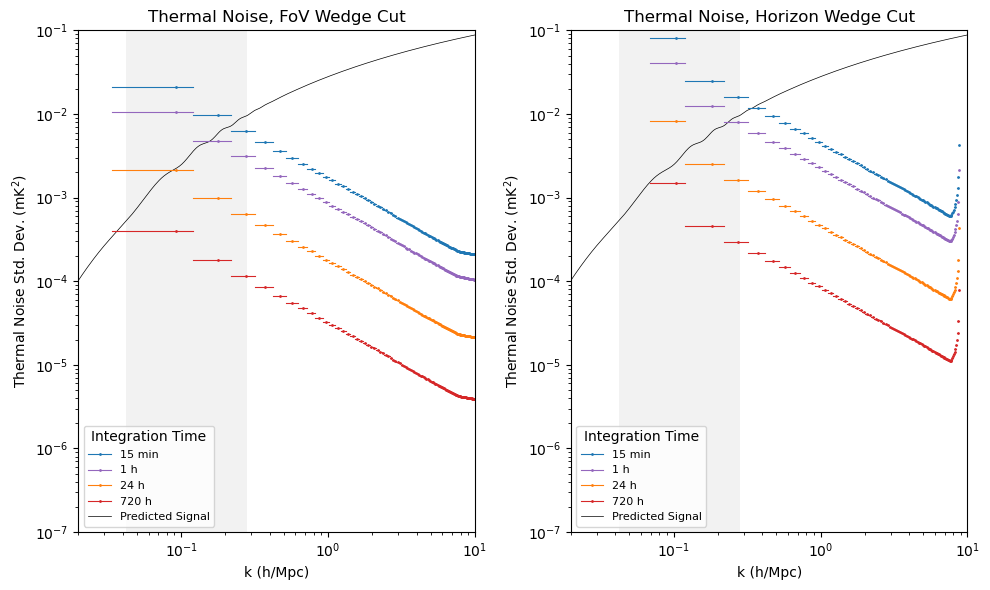

In [13]:
plot_integration_times_h = [.25, 1, 24, 720]
colors = ['tab:blue','tab:purple','tab:orange','tab:red']
legend_labels = [
    "15 min",
    "1 h",
    "24 h",
    "720 h",
    "Predicted Signal",
]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

legend_lines = [Line2D([0], [0], linewidth=0.8, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_variance = binned_ps_variance_fov_cut
        use_true_bin_centers = true_bin_centers_fov_cut
        use_true_bin_edges = true_bin_edges_fov_cut
        title = "Thermal Noise, FoV Wedge Cut"
    else:
        use_binned_ps_variance = binned_ps_variance_horizon_cut
        use_true_bin_centers = true_bin_centers_horizon_cut
        use_true_bin_edges = true_bin_edges_horizon_cut
        title = "Thermal Noise, Horizon Wedge Cut"
        
    # Plot theory line
    ax[wedge_cut_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[wedge_cut_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    for int_time_ind, int_time in enumerate(plot_integration_times_h):
        plot_vals = np.sqrt(use_binned_ps_variance * .25 / int_time)
        ax[wedge_cut_ind].plot(
            use_true_bin_centers,
            plot_vals,
            marker="o", markersize=1, linewidth=0,
            color=colors[int_time_ind],
        )
        for bin_ind in range(len(plot_vals)):  
            ax[wedge_cut_ind].plot(
                use_true_bin_edges[bin_ind, :],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[int_time_ind],
            )
    ax[wedge_cut_ind].set_yscale("log")
    ax[wedge_cut_ind].set_xscale("log")
    ax[wedge_cut_ind].set_xlim(xrange)
    ax[wedge_cut_ind].set_ylim(yrange)
    ax[wedge_cut_ind].set_xlabel("k (h/Mpc)")
    ax[wedge_cut_ind].set_ylabel("Thermal Noise Std. Dev. (mK$^2$)")
    ax[wedge_cut_ind].legend(legend_lines, legend_labels, prop={'size': 8}, title="Integration Time")
    ax[wedge_cut_ind].set_title(title)

plt.tight_layout()
#plt.savefig("plots/thermal_noise_stddev.png")
plt.show()

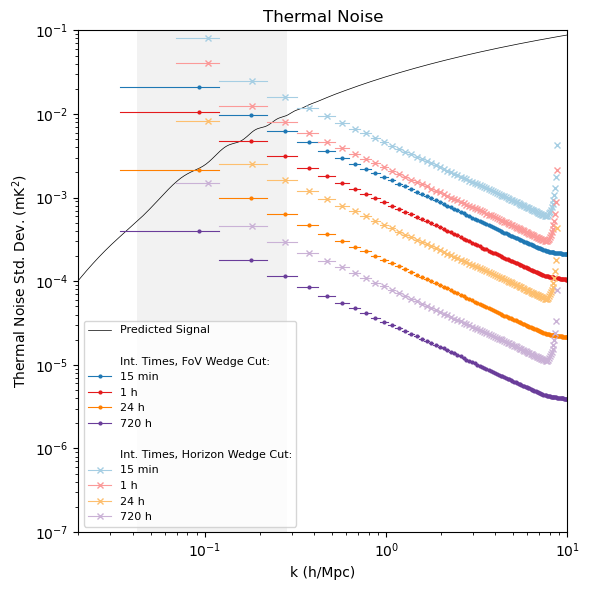

In [14]:
plot_integration_times_h = [.25, 1, 24, 720]
colors = np.array([
    [seaborn.color_palette("Paired")[1], seaborn.color_palette("Paired")[5], seaborn.color_palette("Paired")[7], seaborn.color_palette("Paired")[9]],
    [seaborn.color_palette("Paired")[0], seaborn.color_palette("Paired")[4], seaborn.color_palette("Paired")[6], seaborn.color_palette("Paired")[8]],
])
markers = ["o", "x"]
marker_sizes = [2, 5]
time_int_labels = [
    "15 min",
    "1 h",
    "24 h",
    "720 h",
]
legend_headings = ["Int. Times, FoV Wedge Cut:", "Int. Times, Horizon Wedge Cut:"]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

fig, ax = plt.subplots(figsize=(6,6))

# Plot theory line
ax.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)
legend_lines = [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]
legend_labels = ["Predicted Signal"]

# Plot BAO scales
ax.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for wedge_cut_ind in range(2):
    legend_lines = legend_lines + [Line2D([0], [0], linewidth=0), Line2D([0], [0], linewidth=0)]
    legend_labels = legend_labels + ["", legend_headings[wedge_cut_ind]]
    if wedge_cut_ind == 0:
        use_binned_ps_variance = binned_ps_variance_fov_cut
        use_true_bin_centers = true_bin_centers_fov_cut
        use_true_bin_edges = true_bin_edges_fov_cut
    else:
        use_binned_ps_variance = binned_ps_variance_horizon_cut
        use_true_bin_centers = true_bin_centers_horizon_cut
        use_true_bin_edges = true_bin_edges_horizon_cut
        
    for int_time_ind, int_time in enumerate(plot_integration_times_h):
        legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.8, marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], color=colors[wedge_cut_ind, int_time_ind, :])]
        legend_labels = legend_labels + [time_int_labels[int_time_ind]]
        
        plot_vals = np.sqrt(use_binned_ps_variance * .25 / int_time)
        ax.plot(
            use_true_bin_centers,
            plot_vals,
            marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], linewidth=0,
            color=colors[wedge_cut_ind, int_time_ind, :],
        )
        for bin_ind in range(len(plot_vals)):  
            ax.plot(
                use_true_bin_edges[bin_ind, :],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[wedge_cut_ind, int_time_ind, :],
            )
            
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Thermal Noise Std. Dev. (mK$^2$)")
ax.legend(legend_lines, legend_labels, prop={'size': 8})
ax.set_title("Thermal Noise")

plt.tight_layout()
plt.savefig("plots/thermal_noise_stddev.png")
plt.show()

In [15]:
binned_ps_sample_variance_horizon_cut = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=90.0,
)
binned_ps_sample_variance_fov_cut = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=3.09,
)

Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07
Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07


/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/3370479513.py:33: RuntimeWarning: invalid value encountered in sqrt
  plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)


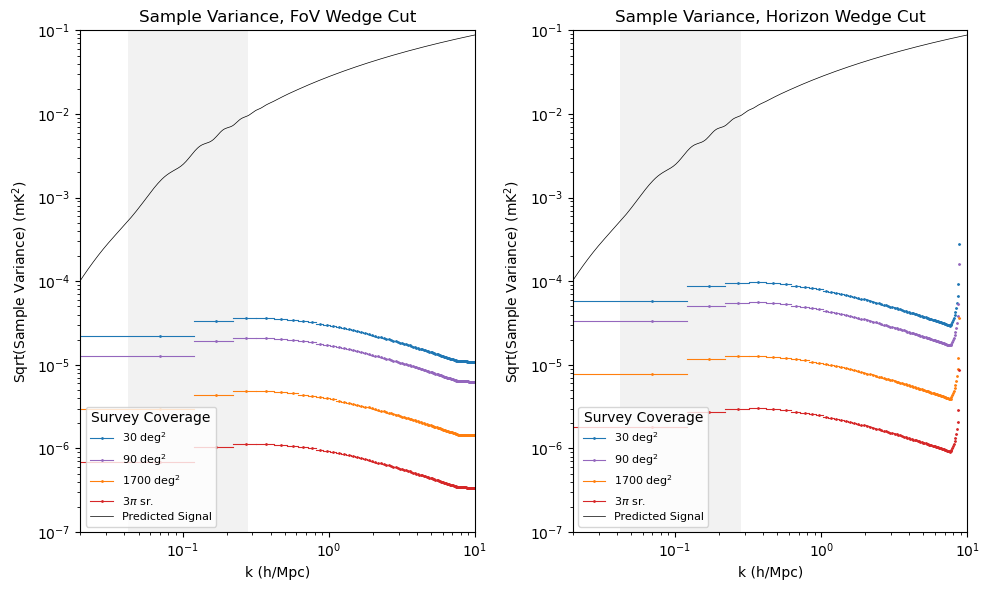

In [16]:
plot_fov_deg = [30.0, 90.0, 1700.0, 3*np.pi*(180/np.pi)**2.]
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
legend_labels = [
    "30 deg$^2$",
    "90 deg$^2$",
    "1700 deg$^2$",
    "3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

legend_lines = [Line2D([0], [0], linewidth=0.8, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_sample_variance = binned_ps_sample_variance_fov_cut
        title = "Sample Variance, FoV Wedge Cut"
    else:
        use_binned_ps_sample_variance = binned_ps_sample_variance_horizon_cut
        title = "Sample Variance, Horizon Wedge Cut"
        
    # Plot theory line
    ax[wedge_cut_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[wedge_cut_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    for fov_ind, use_fov in enumerate(plot_fov_deg):
        plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)
        ax[wedge_cut_ind].plot(
            (bin_edges[:-1] + bin_edges[1:]) / 2,
            plot_vals,
            marker="o", markersize=1, linewidth=0,
            color=colors[fov_ind],
        )
        for bin_ind in range(len(plot_vals)):  
            ax[wedge_cut_ind].plot(
                [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[fov_ind],
            )
    ax[wedge_cut_ind].set_yscale("log")
    ax[wedge_cut_ind].set_xscale("log")
    ax[wedge_cut_ind].set_xlim(xrange)
    ax[wedge_cut_ind].set_ylim(yrange)
    ax[wedge_cut_ind].set_xlabel("k (h/Mpc)")
    ax[wedge_cut_ind].set_ylabel("Sqrt(Sample Variance) (mK$^2$)")
    ax[wedge_cut_ind].legend(legend_lines, legend_labels, prop={'size': 8}, title="Survey Coverage")
    ax[wedge_cut_ind].set_title(title)

plt.tight_layout()
#plt.savefig("plots/sample_stddev.png")
plt.show()

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/1918350525.py:42: RuntimeWarning: invalid value encountered in sqrt
  plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)
/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/1918350525.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/1918350525.py:68: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("plots/sample_stddev.png")
/Users/ruby/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


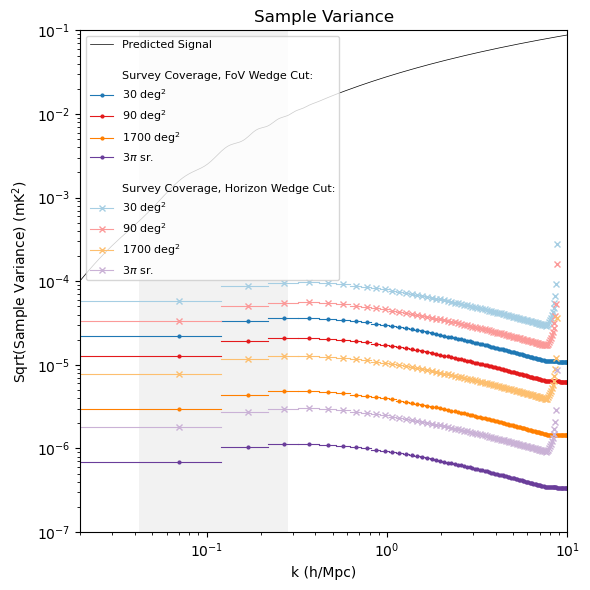

In [17]:
plot_fov_deg = [30.0, 90.0, 1700.0, 3*np.pi*(180/np.pi)**2.]

colors = np.array([
    [seaborn.color_palette("Paired")[1], seaborn.color_palette("Paired")[5], seaborn.color_palette("Paired")[7], seaborn.color_palette("Paired")[9]],
    [seaborn.color_palette("Paired")[0], seaborn.color_palette("Paired")[4], seaborn.color_palette("Paired")[6], seaborn.color_palette("Paired")[8]],
])
markers = ["o", "x"]
marker_sizes = [2, 5]
fov_int_labels = [
    "30 deg$^2$",
    "90 deg$^2$",
    "1700 deg$^2$",
    "3$\pi$ sr.",
]
legend_headings = ["Survey Coverage, FoV Wedge Cut:", "Survey Coverage, Horizon Wedge Cut:"]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

fig, ax = plt.subplots(figsize=(6,6))

# Plot theory line
ax.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)
legend_lines = [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]
legend_labels = ["Predicted Signal"]

# Plot BAO scales
ax.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_sample_variance = binned_ps_sample_variance_fov_cut
    else:
        use_binned_ps_sample_variance = binned_ps_sample_variance_horizon_cut
        
    legend_lines = legend_lines + [Line2D([0], [0], linewidth=0), Line2D([0], [0], linewidth=0)]
    legend_labels = legend_labels + ["", legend_headings[wedge_cut_ind]]
        
    for fov_ind, use_fov in enumerate(plot_fov_deg):
        legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.8, marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], color=colors[wedge_cut_ind, fov_ind, :])]
        legend_labels = legend_labels + [fov_int_labels[fov_ind]]
        
        plot_vals = np.sqrt(use_binned_ps_sample_variance * field_of_view_deg2 / use_fov)
        ax.plot(
            (bin_edges[:-1] + bin_edges[1:]) / 2,
            plot_vals,
            marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], linewidth=0,
            color=colors[wedge_cut_ind, fov_ind, :],
        )
        for bin_ind in range(len(plot_vals)):  
            ax.plot(
                [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[wedge_cut_ind, fov_ind, :],
            )
            
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Sqrt(Sample Variance) (mK$^2$)")
ax.legend(legend_lines, legend_labels, prop={'size': 8})
ax.set_title("Sample Variance")

plt.tight_layout()
plt.savefig("plots/sample_stddev.png")
plt.show()

In [18]:
binned_ps_shot_noise_horizon_cut = array_sensitivity.get_shot_noise(
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=90.0,
)
binned_ps_shot_noise_fov_cut = array_sensitivity.get_shot_noise(
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=3.09,
)

Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07
Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07


/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/1271146605.py:33: RuntimeWarning: invalid value encountered in sqrt
  plot_vals = np.sqrt(use_binned_ps_shot_noise * field_of_view_deg2 / use_fov)


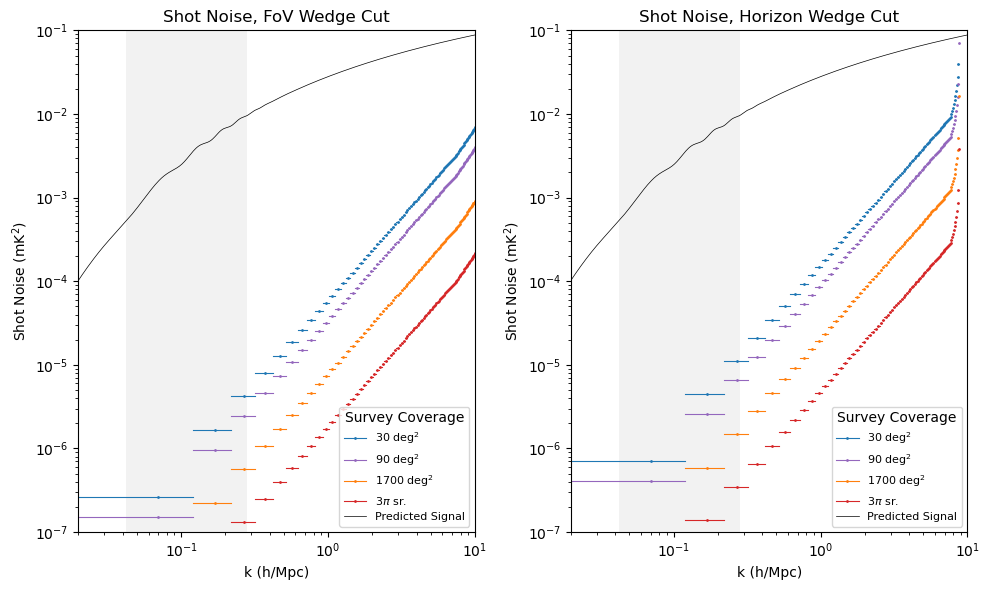

In [19]:
plot_fov_deg = [30.0, 90.0, 1700.0, 3*np.pi*(180/np.pi)**2.]
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
legend_labels = [
    "30 deg$^2$",
    "90 deg$^2$",
    "1700 deg$^2$",
    "3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

legend_lines = [Line2D([0], [0], linewidth=0.8, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_shot_noise = binned_ps_shot_noise_fov_cut
        title = "Shot Noise, FoV Wedge Cut"
    else:
        use_binned_ps_shot_noise = binned_ps_shot_noise_horizon_cut
        title = "Shot Noise, Horizon Wedge Cut"
        
    # Plot theory line
    ax[wedge_cut_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[wedge_cut_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    for fov_ind, use_fov in enumerate(plot_fov_deg):
        plot_vals = np.sqrt(use_binned_ps_shot_noise * field_of_view_deg2 / use_fov)
        ax[wedge_cut_ind].plot(
            (bin_edges[:-1] + bin_edges[1:]) / 2,
            plot_vals,
            marker="o", markersize=1, linewidth=0,
            color=colors[fov_ind],
        )
        for bin_ind in range(len(plot_vals)):  
            ax[wedge_cut_ind].plot(
                [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[fov_ind],
            )
    ax[wedge_cut_ind].set_yscale("log")
    ax[wedge_cut_ind].set_xscale("log")
    ax[wedge_cut_ind].set_xlim(xrange)
    ax[wedge_cut_ind].set_ylim(yrange)
    ax[wedge_cut_ind].set_xlabel("k (h/Mpc)")
    ax[wedge_cut_ind].set_ylabel("Shot Noise (mK$^2$)")
    ax[wedge_cut_ind].legend(legend_lines, legend_labels, prop={'size': 8}, title="Survey Coverage")
    ax[wedge_cut_ind].set_title(title)

plt.tight_layout()
#plt.savefig("plots/shot_noise.png")
plt.show()

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_94673/1659977055.py:42: RuntimeWarning: invalid value encountered in sqrt
  plot_vals = np.sqrt(use_binned_ps_shot_noise * field_of_view_deg2 / use_fov)


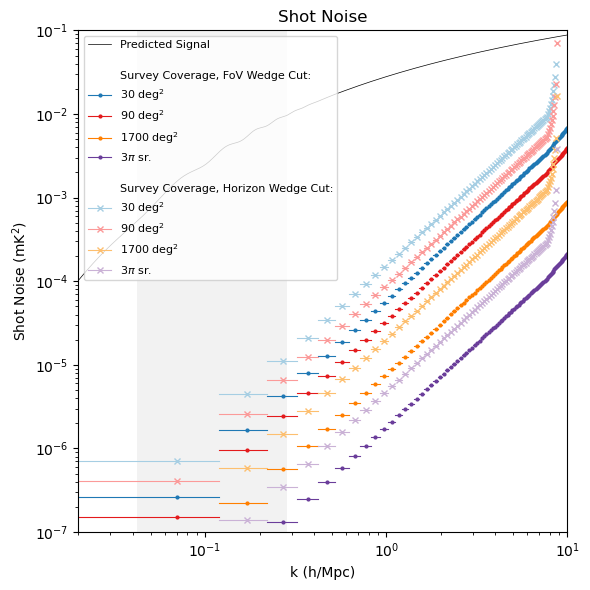

In [20]:
plot_fov_deg = [30.0, 90.0, 1700.0, 3*np.pi*(180/np.pi)**2.]

colors = np.array([
    [seaborn.color_palette("Paired")[1], seaborn.color_palette("Paired")[5], seaborn.color_palette("Paired")[7], seaborn.color_palette("Paired")[9]],
    [seaborn.color_palette("Paired")[0], seaborn.color_palette("Paired")[4], seaborn.color_palette("Paired")[6], seaborn.color_palette("Paired")[8]],
])
markers = ["o", "x"]
marker_sizes = [2, 5]
fov_int_labels = [
    "30 deg$^2$",
    "90 deg$^2$",
    "1700 deg$^2$",
    "3$\pi$ sr.",
]
legend_headings = ["Survey Coverage, FoV Wedge Cut:", "Survey Coverage, Horizon Wedge Cut:"]
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

fig, ax = plt.subplots(figsize=(6,6))

# Plot theory line
ax.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)
legend_lines = [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]
legend_labels = ["Predicted Signal"]

# Plot BAO scales
ax.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for wedge_cut_ind in range(2):
    if wedge_cut_ind == 0:
        use_binned_ps_shot_noise = binned_ps_shot_noise_fov_cut
    else:
        use_binned_ps_shot_noise = binned_ps_shot_noise_horizon_cut
        
    legend_lines = legend_lines + [Line2D([0], [0], linewidth=0), Line2D([0], [0], linewidth=0)]
    legend_labels = legend_labels + ["", legend_headings[wedge_cut_ind]]
        
    for fov_ind, use_fov in enumerate(plot_fov_deg):
        legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.8, marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], color=colors[wedge_cut_ind, fov_ind, :])]
        legend_labels = legend_labels + [fov_int_labels[fov_ind]]
        
        plot_vals = np.sqrt(use_binned_ps_shot_noise * field_of_view_deg2 / use_fov)
        ax.plot(
            (bin_edges[:-1] + bin_edges[1:]) / 2,
            plot_vals,
            marker=markers[wedge_cut_ind], markersize=marker_sizes[wedge_cut_ind], linewidth=0,
            color=colors[wedge_cut_ind, fov_ind, :],
        )
        for bin_ind in range(len(plot_vals)):  
            ax.plot(
                [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
                [plot_vals[bin_ind], plot_vals[bin_ind]],
                marker="none",
                linewidth=0.8,
                color=colors[wedge_cut_ind, fov_ind, :],
            )
            
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Shot Noise (mK$^2$)")
ax.legend(legend_lines, legend_labels, prop={'size': 8}, loc="upper left")
ax.set_title("Shot Noise")

plt.tight_layout()
plt.savefig("plots/shot_noise.png")
plt.show()

In [21]:
combined_variance_fov_cut = (
    (binned_ps_variance_fov_cut * .25 / 720) 
    + ((binned_ps_sample_variance_fov_cut + binned_ps_shot_noise_fov_cut) * field_of_view_deg2 / 1700.0)
)
combined_variance_horizon_cut = (
    (binned_ps_variance_horizon_cut * .25 / 720) 
    + ((binned_ps_sample_variance_horizon_cut + binned_ps_shot_noise_horizon_cut) * field_of_view_deg2 / 1700.0)
)
combined_variance_fov_cut_15_min = binned_ps_variance_fov_cut + binned_ps_sample_variance_fov_cut + binned_ps_shot_noise_fov_cut
combined_variance_horizon_cut_15_min = binned_ps_variance_horizon_cut + binned_ps_sample_variance_horizon_cut + binned_ps_shot_noise_horizon_cut

In [22]:
ps_model_interp = np.interp(true_bin_centers_fov_cut, model_k_axis, ps_model)

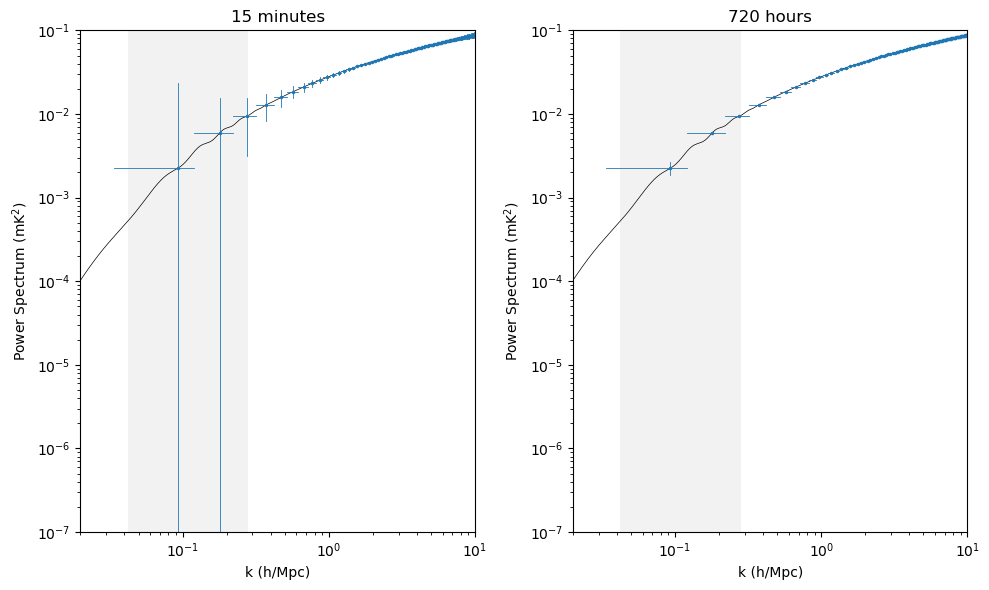

In [23]:
xrange = [2e-2, 10]
yrange = [1e-7, 1e-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

for int_time_ind in range(2):
    if int_time_ind == 0:
        var_use = combined_variance_fov_cut_15_min
        title = "15 minutes"
    else:
        var_use = combined_variance_fov_cut
        title = "720 hours"

    # Plot theory line
    ax[int_time_ind].plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

    # Plot BAO scales
    ax[int_time_ind].fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

    ax[int_time_ind].plot(true_bin_centers_fov_cut, ps_model_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
    for ind in range(len(ps_model_interp)):
        xvals = [true_bin_centers_fov_cut[ind], true_bin_centers_fov_cut[ind]]
        yvals = [
            ps_model_interp[ind] - np.sqrt(var_use[ind]),
            ps_model_interp[ind] + np.sqrt(var_use[ind])
        ]
        ax[int_time_ind].plot(
            xvals,
            yvals,
            color="tab:blue",
            linewidth=0.6,
            marker="none"
        )
        ax[int_time_ind].plot(
            true_bin_edges_fov_cut[ind, :],
            [ps_model_interp[ind], ps_model_interp[ind]],
            marker="none",
            linewidth=0.6,
            color="tab:blue",
        )

    ax[int_time_ind].set_yscale("log")
    ax[int_time_ind].set_xscale("log")
    ax[int_time_ind].set_xlim(xrange)
    ax[int_time_ind].set_ylim(yrange)
    ax[int_time_ind].set_xlabel("k (h/Mpc)")
    ax[int_time_ind].set_ylabel("Power Spectrum (mK$^2$)")
    ax[int_time_ind].set_title(title)
plt.tight_layout()
plt.savefig("plots/error_bars.png")
plt.show()

In [24]:
detected_inds = np.where(ps_model_interp > 5*np.sqrt(combined_variance_fov_cut_15_min))
print(f"Min mode: {np.min(true_bin_edges_fov_cut[detected_inds, 0])}")
print(f"Max mode: {np.max(true_bin_edges_fov_cut[detected_inds, 1])}")
#print(ps_model_interp - 5*np.sqrt(combined_variance_fov_cut))

Min mode: 0.5200022548157159
Max mode: 14.819999997669933


In [25]:
detected_inds = np.where(ps_model_interp > 5*np.sqrt(combined_variance_fov_cut))
print(f"Min mode: {np.min(true_bin_edges_fov_cut[detected_inds, 0])}")
print(f"Max mode: {np.max(true_bin_edges_fov_cut[detected_inds, 1])}")

Min mode: 0.033749221465163834
Max mode: 31.319999987888256


# BAO Analysis

In [26]:
convolution_kernel_fwhm = 0.06
convolution_kernel_stddev = convolution_kernel_fwhm / 2.355
ps_model_fit_values = np.zeros(len(ps_model))
for k_ind, k_val in enumerate(model_k_axis):
    taper_function = np.exp(-(np.array(model_k_axis) - k_val)**2./(convolution_kernel_stddev)**2.)
    ps_model_fit_values[k_ind] = np.sum(taper_function*ps_model)/np.sum(taper_function)
    #ps_model_fit_values[k_ind] = np.nanmean(ps_model[
    #    np.where((model_k_axis > k_val - boxcar_size/2.0) & (model_k_axis < k_val + boxcar_size/2.0))
    #])

In [27]:
print(ps_model_fit_values)

[1.42121241e-05 1.42140533e-05 1.42160209e-05 1.42180271e-05
 1.42200815e-05 1.42221744e-05 1.42243058e-05 1.42264855e-05
 1.42287038e-05 1.42309703e-05 1.42332851e-05 1.42356482e-05
 1.42380499e-05 1.42405096e-05 1.42430177e-05 1.42455837e-05
 1.42481885e-05 1.42508514e-05 1.42535724e-05 1.42563515e-05
 1.42591791e-05 1.42620745e-05 1.42650185e-05 1.42680304e-05
 1.42711006e-05 1.42742292e-05 1.42774257e-05 1.42806903e-05
 1.42840231e-05 1.42874143e-05 1.42908834e-05 1.42944208e-05
 1.42980361e-05 1.43017198e-05 1.43054816e-05 1.43093215e-05
 1.43132301e-05 1.43172265e-05 1.43213110e-05 1.43254739e-05
 1.43297154e-05 1.43340547e-05 1.43384824e-05 1.43429986e-05
 1.43476033e-05 1.43523063e-05 1.43571078e-05 1.43620078e-05
 1.43670064e-05 1.43721134e-05 1.43773194e-05 1.43826340e-05
 1.43880575e-05 1.43935996e-05 1.43992509e-05 1.44050211e-05
 1.44109105e-05 1.44169192e-05 1.44230473e-05 1.44293146e-05
 1.44357017e-05 1.44422283e-05 1.44488848e-05 1.44556813e-05
 1.44626179e-05 1.446970

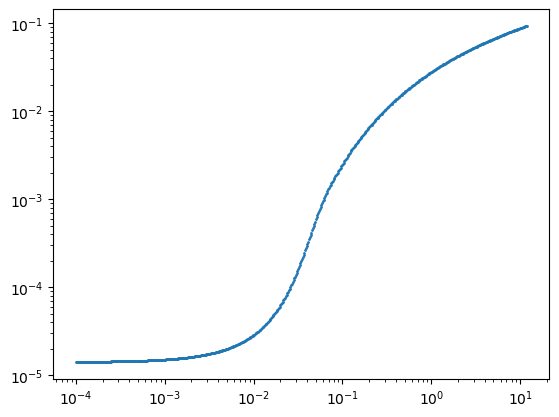

In [28]:
plt.plot(model_k_axis, ps_model_fit_values,"o", markersize=1)
plt.yscale("log")
plt.xscale("log")

In [29]:
#fit_min_val = 1e-2
#fit_max_val = .5
#model_k_axis_bao_scales = [k for k in model_k_axis if (k>=fit_min_val) and (k<=fit_max_val)]
#ps_model_bao_scales = [ps_model[ind] for ind in range(len(model_k_axis)) if (model_k_axis[ind]>=fit_min_val) and (model_k_axis[ind]<=fit_max_val)]

#polyfit = np.polyfit(model_k_axis_bao_scales, ps_model_bao_scales, 4)
#ps_model_fit_values = polyfit[-1]
#for polyfit_ind in range(len(polyfit)-1):
#    ps_model_fit_values += polyfit[polyfit_ind] * np.array(model_k_axis)**(len(polyfit)-1-polyfit_ind)

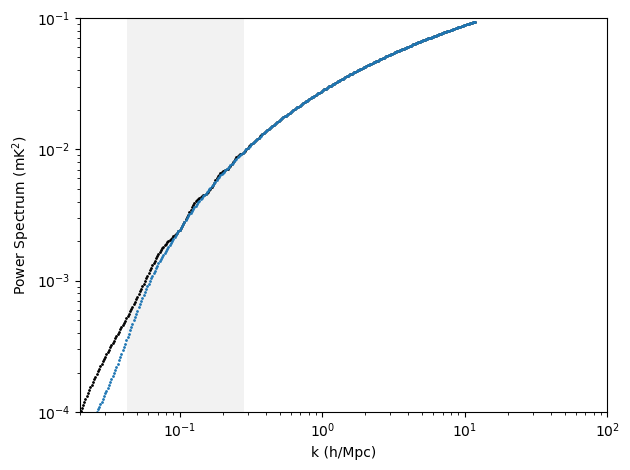

In [30]:
xrange = [2e-2, 100]
yrange = [1e-4, 1e-1]

# Plot theory line
plt.plot(model_k_axis, ps_model, "o", color="black", linewidth=0, markersize=1)
plt.plot(model_k_axis, ps_model_fit_values,"o", markersize=1)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.tight_layout()
plt.show()

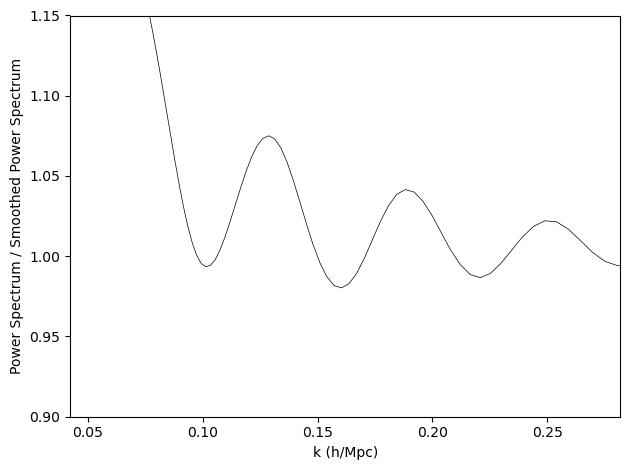

In [31]:
xrange = bao_scales_k
yrange = [.9,1.15]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)
#plt.plot(bin_edges_bao, [1]*len(bin_edges_bao), "o", color="black", linewidth=0, markersize=1)

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
#plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.show()

In [32]:
# Find peaks
model_k_axis = np.array(model_k_axis)
ps_ratio = ps_model/ps_model_fit_values
use_inds = np.where((model_k_axis > 0.05) & (model_k_axis < 0.1))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.1) & (model_k_axis < 0.15))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.15) & (model_k_axis < 0.23))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])
use_inds = np.where((model_k_axis > 0.23) & (model_k_axis < 0.27))
print(model_k_axis[list(ps_ratio).index(np.max(ps_ratio[use_inds]))])

0.05027
0.12869
0.18818
0.24899


In [33]:
print(0.25402-0.18818)
print(0.18818-0.12869)
print(0.12869-0.07351)
print(np.mean([0.25402-0.18818,0.18818-0.12869,0.12869-0.07351])/2)

0.06584000000000004
0.05948999999999999
0.05517999999999999
0.030085


In [34]:
k_bin_size_bao = 0.03
min_k_bao = 0.12869 - 2.5*k_bin_size_bao
max_k_bao = .35
bin_edges_bao = np.arange(min_k_bao, max_k_bao, k_bin_size_bao)
print(bin_edges_bao)

[0.05369 0.08369 0.11369 0.14369 0.17369 0.20369 0.23369 0.26369 0.29369
 0.32369]


In [194]:
(
    null,
    binned_ps_variance_bao,
    true_bin_edges_bao,
    true_bin_centers_bao,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=3.09,
    zenith_angle=0.0,
)
(
    null,
    binned_ps_variance_bao_offaxis,
    true_bin_edges_bao_offaxis,
    true_bin_centers_bao_offaxis,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=3.09,
    zenith_angle=60.0,
)
(
    null,
    binned_ps_variance_bao_core,
    true_bin_edges_bao_core,
    true_bin_centers_bao_core,
    null,
    null,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath="W2-17_core_test_200.cfg",
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=1000,
    k_bin_edges_1d=bin_edges_bao,
    kpar_bin_edges=bin_edges_bao,
    kperp_bin_edges=bin_edges_bao,
    wedge_extent_deg=3.09,
    zenith_angle=0.0,
)
binned_ps_sample_variance_bao = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges_bao,
    wedge_extent_deg=3.09,
)
binned_ps_shot_noise_bao = array_sensitivity.get_shot_noise(
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges_bao,
    wedge_extent_deg=3.09,
)
combined_variance_bao = (
    (binned_ps_variance_bao * .25 / 720) 
    + ((binned_ps_sample_variance_bao + binned_ps_shot_noise_bao) * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_bao_offaxis = (
    (binned_ps_variance_bao_offaxis * .25 / 720) 
    + ((binned_ps_sample_variance_bao + binned_ps_shot_noise_bao) * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)
combined_variance_bao_core = (
    (binned_ps_variance_bao_core * .25 / 720) 
    + ((binned_ps_sample_variance_bao + binned_ps_shot_noise_bao) * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07
Kpar correlation length: 0.002736362210334458
Kperp correlation length: 0.015331664324187
Correlation volume: 6.432091122141715e-07


In [195]:
ps_ratio_interp = np.interp(true_bin_centers_bao, model_k_axis, ps_ratio)
ps_model_fit_values_interp = np.interp(true_bin_centers_bao, model_k_axis, ps_model_fit_values)

combined_variance_bao_ratio = combined_variance_bao / ps_model_fit_values_interp**2.
combined_variance_bao_ratio_offaxis = combined_variance_bao_offaxis / ps_model_fit_values_interp**2.
combined_variance_bao_ratio_core = combined_variance_bao_core / ps_model_fit_values_interp**2.

In [196]:
print(bao_scales_k)

[0.04225352 0.28169014]


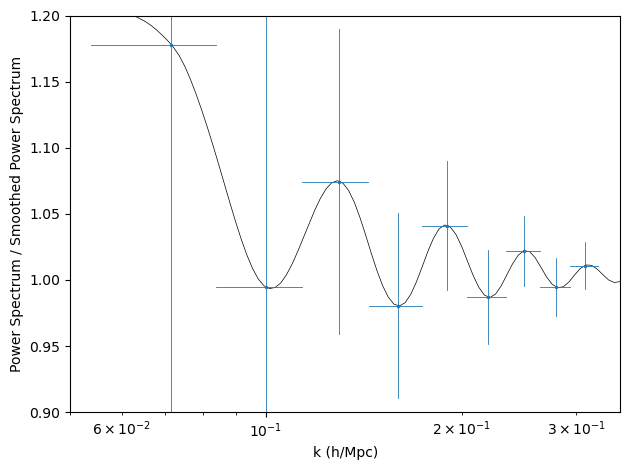

In [197]:
xrange = [0.05,0.35]
yrange = [.9,1.2]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars.png")
plt.show()

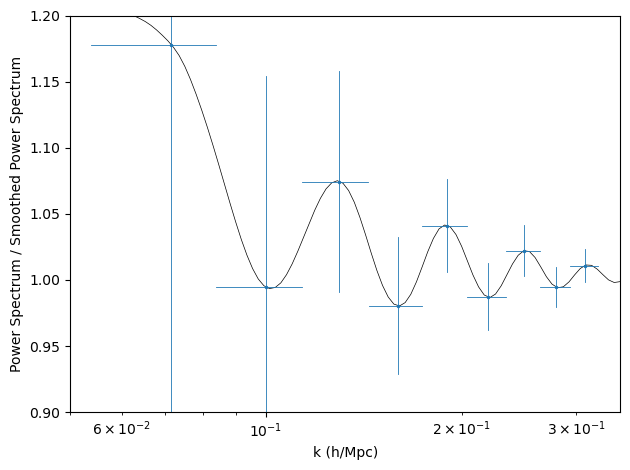

In [198]:
xrange = [0.05,0.35]
yrange = [.9,1.2]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio_offaxis[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio_offaxis[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars_offaxis.png")
plt.show()

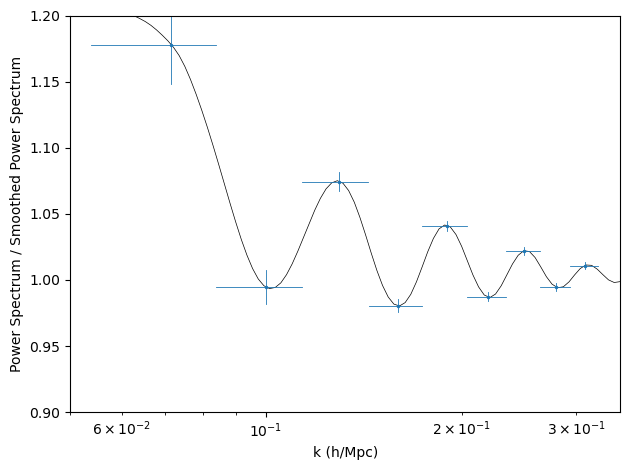

In [199]:
xrange = [0.05,0.35]
yrange = [.9,1.2]

# Plot theory line
plt.plot(model_k_axis, ps_model/ps_model_fit_values, "-", color="black", linewidth=0.5, markersize=0)

plt.plot(true_bin_centers_bao, ps_ratio_interp, marker="o", color="tab:blue", linewidth=0, markersize=1.5)
for ind in range(len(ps_ratio_interp)):
    xvals = [true_bin_centers_bao[ind], true_bin_centers_bao[ind]]
    yvals = [
        ps_ratio_interp[ind] - np.sqrt(combined_variance_bao_ratio_core[ind]),
        ps_ratio_interp[ind] + np.sqrt(combined_variance_bao_ratio_core[ind])
    ]
    plt.plot(
        xvals,
        yvals,
        color="tab:blue",
        linewidth=0.6,
        marker="none"
    )
    plt.plot(
        true_bin_edges_bao[ind, :],
        [ps_ratio_interp[ind], ps_ratio_interp[ind]],
        marker="none",
        linewidth=0.6,
        color="tab:blue",
    )
    

# Plot BAO scales
#plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

#plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum / Smoothed Power Spectrum")
plt.tight_layout()
plt.savefig("plots/bao_error_bars_core.png")
plt.show()

In [200]:
# Is there a 5 sigma detection of each feature?
for feature_ind in range(8):
    bao_feature_depth = np.abs(ps_ratio_interp[feature_ind] - ps_ratio_interp[feature_ind+1])
    measurement_var = combined_variance_bao_ratio_core[feature_ind] + combined_variance_bao_ratio_core[feature_ind+1]
    print(bao_feature_depth/np.sqrt(measurement_var))

5.667669340781455
5.467291197547819
10.725541757919293
9.472671718439006
10.33688730627055
7.581064515240343
6.635939510984464
4.33206296739248


In [64]:
antlocs_core = array_sensitivity.get_antpos("W2-17_core_test_30m.cfg")
baselines_core = array_sensitivity.get_baselines(antlocs_core)
antlocs_core = antlocs_core[-200:, :]
core_plot_size_m = 200

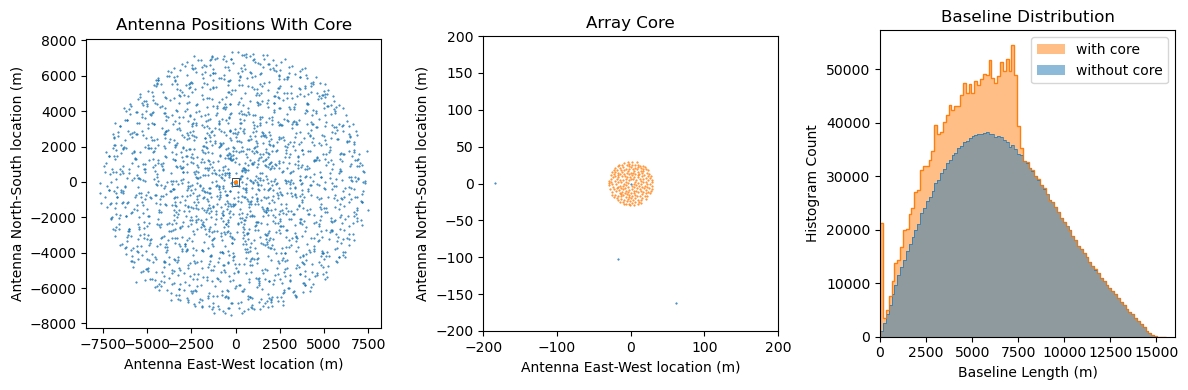

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0, color="tab:blue")
ax[0].plot(antlocs_core[:,0], antlocs_core[:,1], marker="o", markersize=.5, linewidth=0, color="tab:orange")
ax[0].set_aspect(1)
ax[0].set_xlabel("Antenna East-West location (m)")
ax[0].set_ylabel("Antenna North-South location (m)")
ax[0].set_title("Antenna Positions With Core")
ax[0].add_patch(
    Rectangle((-core_plot_size_m, -core_plot_size_m), 2*core_plot_size_m, 2*core_plot_size_m, edgecolor = 'black', fill=False, lw=0.5)         
)
ax[0].set_aspect("equal")

ax[1].plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0, color="tab:blue")
ax[1].plot(antlocs_core[:,0], antlocs_core[:,1], marker="o", markersize=.5, linewidth=0, color="tab:orange")
ax[1].set_aspect(1)
ax[1].set_xlabel("Antenna East-West location (m)")
ax[1].set_ylabel("Antenna North-South location (m)")
ax[1].set_title("Array Core")
ax[1].set_aspect("equal")
ax[1].set_xlim([-core_plot_size_m, core_plot_size_m])
ax[1].set_ylim([-core_plot_size_m, core_plot_size_m])

ax[2].hist(
    np.sqrt(np.sum(baselines_core**2., axis=1)),
    bins=100,
    color="tab:orange",
    label="with core",
    alpha=0.5
)
ax[2].hist(
    np.sqrt(np.sum(baselines_core**2., axis=1)),
    bins=100,
    linewidth=1,
    color="tab:orange",
    histtype="step"
)
ax[2].hist(
    np.sqrt(np.sum(baselines_m**2., axis=1)),
    bins=100,
    color="tab:blue",
    label="without core",
    alpha=0.5,
)

ax[2].hist(
    np.sqrt(np.sum(baselines_m**2., axis=1)),
    bins=100,
    linewidth=.5,
    color="tab:blue",
    histtype="step"
)
ax[2].hist(
    np.sqrt(np.sum(baselines_core**2., axis=1)),
    bins=100,
    linewidth=.5,
    color="tab:orange",
    histtype="step"
)
ax[2].set_xlabel("Baseline Length (m)")
ax[2].set_ylabel("Histogram Count")
ax[2].set_title("Baseline Distribution")
ax[2].set_xlim([0,16000])
plt.legend()

plt.tight_layout()
plt.savefig("plots/antlocs_core.png", dpi=600)
plt.show()

In [66]:
print(np.pi*30**2.)
print(9*200)

2827.4333882308138
1800


# Generate PSF Image

In [47]:
# Restore PSF simulation
with open("simulation_outputs/psf.npy", "rb") as f:
    psf = np.load(f)
    frequencies = np.load(f)
    ew_axis = np.load(f)
    ns_axis = np.load(f)
f.close()

In [48]:
np.nanmax(psf)

2068064.9395488538

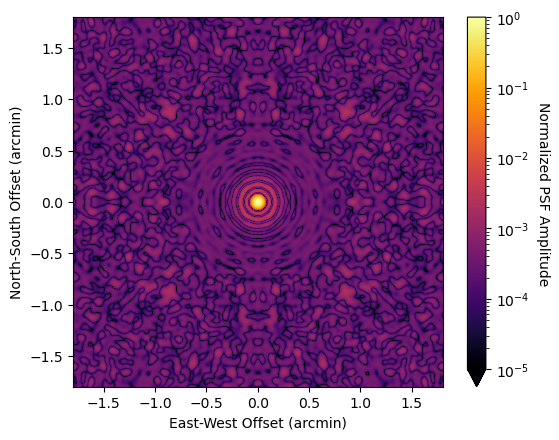

In [49]:
image_extent_arcmin = .03*60.0
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    np.abs(psf[0,:,:])/np.nanmax(np.abs(psf[0,:,:])),
    origin="lower",
    interpolation="none",
    extent=[
        np.min(ew_axis*60),
        np.max(ew_axis*60),
        np.min(ns_axis*60),
        np.max(ns_axis*60)
    ],
    vmin=1e-5,
    vmax=1,
    cmap=use_cmap,
    norm="log",
    aspect=1.,
)
ax.set_xlabel("East-West Offset (arcmin)")
ax.set_ylabel("North-South Offset (arcmin)")
ax.set_xlim([-image_extent_arcmin, image_extent_arcmin])
ax.set_ylim([-image_extent_arcmin, image_extent_arcmin])
cbar = fig.colorbar(cax, extend="min")
cbar.set_label("Normalized PSF Amplitude", rotation=270, labelpad=15)
plt.savefig("plots/psf.png", dpi=600)
plt.show()